# VGGNet和图像语义分割

# VGGNet
VGGNet 探索了使用更小的卷积核（3x3）来构建更深的网络。

*   **为什么用小的3x3卷积核？**
    *   **相同的感受野，更少的参数**：堆叠三个3x3的卷积层和一个7x7的卷积层具有相同的“有效感受野”（Effective Receptive Field），即它们能“看到”的输入图像区域大小是相同的（都是7x7）。
    *   **更多非线性变换**：堆叠三层意味着经过了三次ReLU激活函数，而非线性能力越强，模型的表达能力就越强。
    *   **参数更少**：假设通道数都为C，三个3x3卷积层的参数量是 `3 * (3*3*C*C) = 27*C²`，而一个7x7卷积层的参数量是 `7*7*C*C = 49*C²`。参数量更少，模型更轻量，也更容易训练。

*   **假设通道数都为C，三个3x3卷积层的参数量是 3 * (33CC) = 27C²为什么是C²不是C**  
    *   为了得到**一个输出通道**，我们需要的参数数量是：  
        * `参数量 = 卷积核高 × 卷积核宽 × 输入通道数`  
        * `参数量 = 3 × 3 × C_in`  
    *   通常，一个卷积层不会只生成一个输出通道，它会生成很多个，比如 `C_out` 个。每一个输出通道都代表一种从输入中提取出来的特定特征（比如一个通道检测水平边缘，另一个检测垂直边缘等）。由于每个输出通道都需要一个**独立的卷积核**来生成，所以：
        * `总参数量 = (每个卷积核的参数量) × (输出通道数)`
        * `总参数量 = (3 × 3 × C_in) × C_out`

# RESNET
ResNet：解决“深度”的瓶颈

当网络变得非常深时，会出现“**网络退化**”（Degradation）问题：训练集上的准确率不升反降。ResNet（残差网络）的出现完美解决了这个问题。

*   **核心思想：残差学习（Residual Learning）**
    *   **结构**：引入了“**残差块**”（Residual Block），包含一个“**捷径连接**”（Shortcut/Skip Connection）。
    *   **原理**：传统网络学习的是如何将输入`x`映射到输出`H(x)`。而ResNet学习的是“残差”`F(x) = H(x) - x`。这样，原始的输出就变成了 `H(x) = F(x) + x`。
    *   **好处**：如果某一层不需要做任何变换，模型只需要把残差`F(x)`学成0即可，`H(x)`就等于`x`，实现了“恒等映射”。这使得信息可以无损地跨层传播，极大地缓解了梯度消失和网络退化问题，让构建数百甚至上千层的网络成为可能。

*   **Bottleneck结构**：
    *   在更深的ResNet（如50层以上）中，为了提高效率，使用了“瓶颈”结构。
    *   它由 `1x1卷积` -> `3x3卷积` -> `1x1卷积` 组成。第一个1x1卷积用来降维（减少通道数），减少3x3卷积的计算量，最后一个1x1卷积再把维度升回去。这在不牺牲性能的前提下，大大减少了参数量和计算成本。
    
## 1*1的卷积核有什么用？
可以将`1x1`卷积理解为一种在**所有通道上进行“融合”和“重组”**的工具。它就像一个**应用于每个像素位置的迷你全连接网络**。

下面是`1x1`卷积的几个核心作用：

---

### 1. 改变通道数（降维或升维）

这是`1x1`卷积最常见、最重要的用途。它可以灵活地控制特征图的深度（通道数），就像一个阀门。

*   **降维（Dimensionality Reduction）**：
    假设你的输入特征图尺寸为 `28 × 28 × 256`（256个通道）。如果你想减少计算量，可以应用一个有**64个**`1x1`卷积核的卷积层。
    *   每个`1x1`卷积核的真实尺寸是 `1 × 1 × 256`。
    *   这64个卷积核会产生64个新的通道。
    *   **输出**：你将得到一个 `28 × 28 × 64` 的特征图。

    **效果**：在不改变空间尺寸（高和宽）的情况下，你将通道数从256个大幅减少到了64个。

*   **升维（Increasing Dimensions）**：
    反之，如果你有一个 `28 × 28 × 64` 的输入，想把它恢复到256个通道，你只需要使用**256个**`1x1`的卷积核即可。

---

### 2. 减少计算成本（构成“瓶颈层”）

这是**降维**作用的直接应用，也是ResNet和GoogLeNet等网络能够做得又深又高效的关键。这正是课程所展示的**Bottleneck**结构。

我们来做一个直接的计算对比：

**场景**：输入是 `28 × 28 × 256`，我们想应用一个 `3x3` 的卷积，并且保持输出通道数不变，仍然是 `28 × 28 × 256`。

*   **方案A：直接使用`3x3`卷积**
    *   需要的卷积核数量：256个
    *   每个卷积核的参数量：`3 × 3 × 256` (输入通道)
    *   **总参数量** = `(3 × 3 × 256) × 256` (输出通道) = **589,824**

*   **方案B：使用“瓶颈”结构（1x1 -> 3x3 -> 1x1）**
    1.  **降维**：先用 `64` 个 `1x1` 卷积核将 `28x28x256` 降维到 `28x28x64`。
        *   参数量 = `(1 × 1 × 256) × 64` = 16,384
    2.  **核心卷积**：在降维后的 `28x28x64` 特征图上，使用 `64` 个 `3x3` 卷积核。
        *   参数量 = `(3 × 3 × 64) × 64` = 36,864
    3.  **升维**：最后用 `256` 个 `1x1` 卷积核将 `28x28x64` 恢复到 `28x28x256`。
        *   参数量 = `(1 × 1 × 64) × 256` = 16,384
    *   **总参数量** = 16,384 + 36,864 + 16,384 = **69,632**

**对比结果**：
通过引入`1x1`卷积构成瓶颈层，参数量从约 **59万** 降低到了约 **7万**，减少了将近 **9倍**！计算量也随之大幅下降，但模型依然可以学习到丰富的空间特征（通过中间的`3x3`卷积）。

---

### 3. 增加非线性

卷积层之后通常会跟一个非线性激活函数（如ReLU）。

*   `1x1`卷积本身是一个线性操作（加权求和）。
*   但是，在它后面加上一个ReLU，就为网络增加了一次**非线性变换**。

这使得网络可以在不改变空间分辨率、不增加太多计算成本的情况下，提升模型的表达能力，学习到更复杂的特征组合。

### 总结

| 功能 | 解释 | 应用场景 |
| :--- | :--- | :--- |
| **改变通道数** | 像一个通道调节阀，灵活地增加或减少特征图的深度。 | 控制模型复杂度，为瓶颈层做准备。 |
| **减少计算量** | 通过先降维再做昂贵的空间卷积，最后再升维，大幅降低参数和计算。 | **ResNet的瓶颈结构**，**GoogLeNet的Inception模块**。 |
| **增加非线性** | 在不影响高宽的情况下，为模型注入更多的非线性表达能力。 | 深化网络，增强模型的学习能力。 |

所以，`1x1`卷积是一个非常强大且高效的工具，它让研究者们可以更灵活、更经济地设计出又深又强大的现代神经网络架构。

# 图像语义分割
## 1. 什么是语义分割？

*   **定义**：语义分割是一种**像素级别**的分类任务。它不只是识别图像里有什么（分类），也不只是框出物体在哪里（检测），而是要为图像中的**每一个像素**都分配一个类别标签（比如：人、草地、天空）。

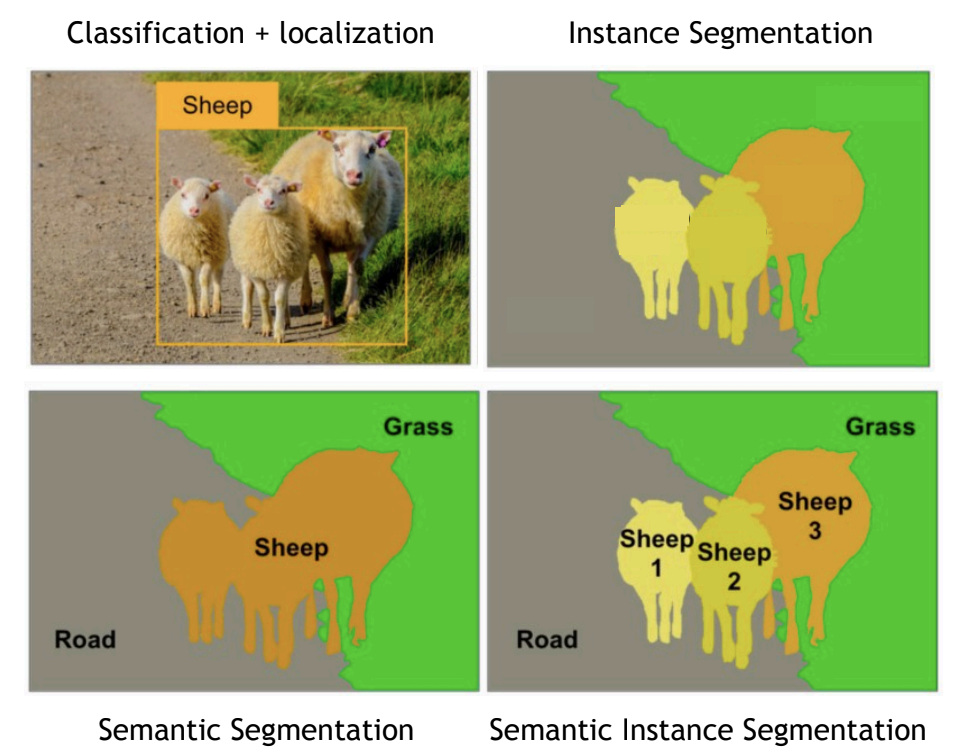

## 2. 全卷积网络（FCN）与编码器-解码器
   **早期方法的局限**：如果用一个小的滑动窗口去判断每个像素的类别，会丢失全局信息，而且效率极低。
*   **FCN的革命性思想**：
    1.  将传统分类网络（如VGG）末尾的全连接层（FC Layer）换成卷积层。
    2.  这样网络就可以接受任意尺寸的输入，并输出一个与输入空间尺寸相关的特征图（heatmap），实现了端到端的像素级预测。

*   **编码器-解码器（Encoder-Decoder）结构**：
    *   **编码器（Encoder）**：通常是一个预训练的分类网络（如VGG或ResNet），负责提取图像特征。在这个过程中，特征图的**空间分辨率会不断降低**（下采样），但语义信息会更丰富。这个过程就像在“压缩”和“理解”图像。
    *   **解码器（Decoder）**：负责将编码器输出的低分辨率、高语义的特征图**恢复到原始图像的分辨率**（上采样），从而实现对每个像素的预测。
    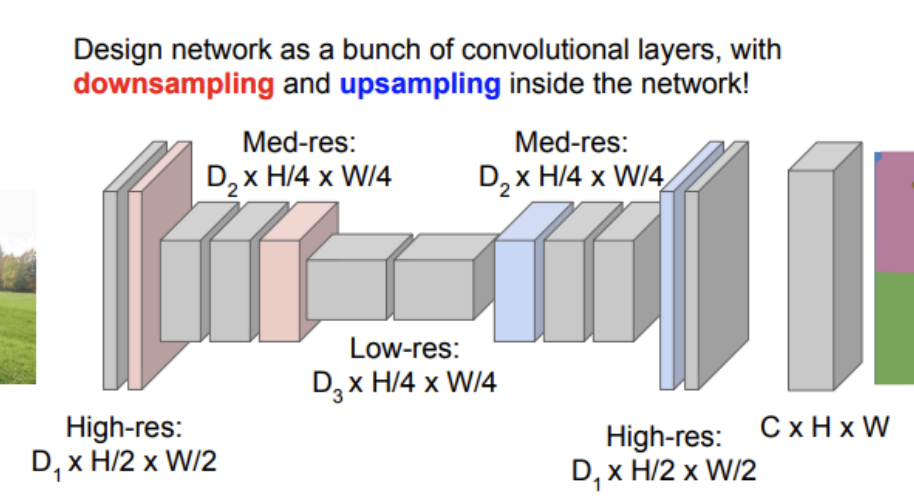

## 3. 上采样（Upsampling）方法

为了从低分辨率特征图恢复到高分辨率，需要上采样技术：

*   **Unpooling（反池化）**：
    *   **最近邻**：直接复制像素值。
    *   **Bed of Nails**：将像素放在固定位置，其余补零。
    *   **Max Unpooling**：在下采样做Max Pooling时记住最大值的位置，上采样时将值放回原位。
    

### 转置卷积（Transposed Convolution）
**核心思想：将输入中的每个像素“投射”或“扩散”到一个更大的输出区域。**

> 输入中的**一个**像素，会影响（贡献权重）到输出中的一个**邻域（比如3x3）**。

这就像把标准卷积的“多对一”映射关系，在连接形式上反转过来，变成了“一对多”的映射关系。

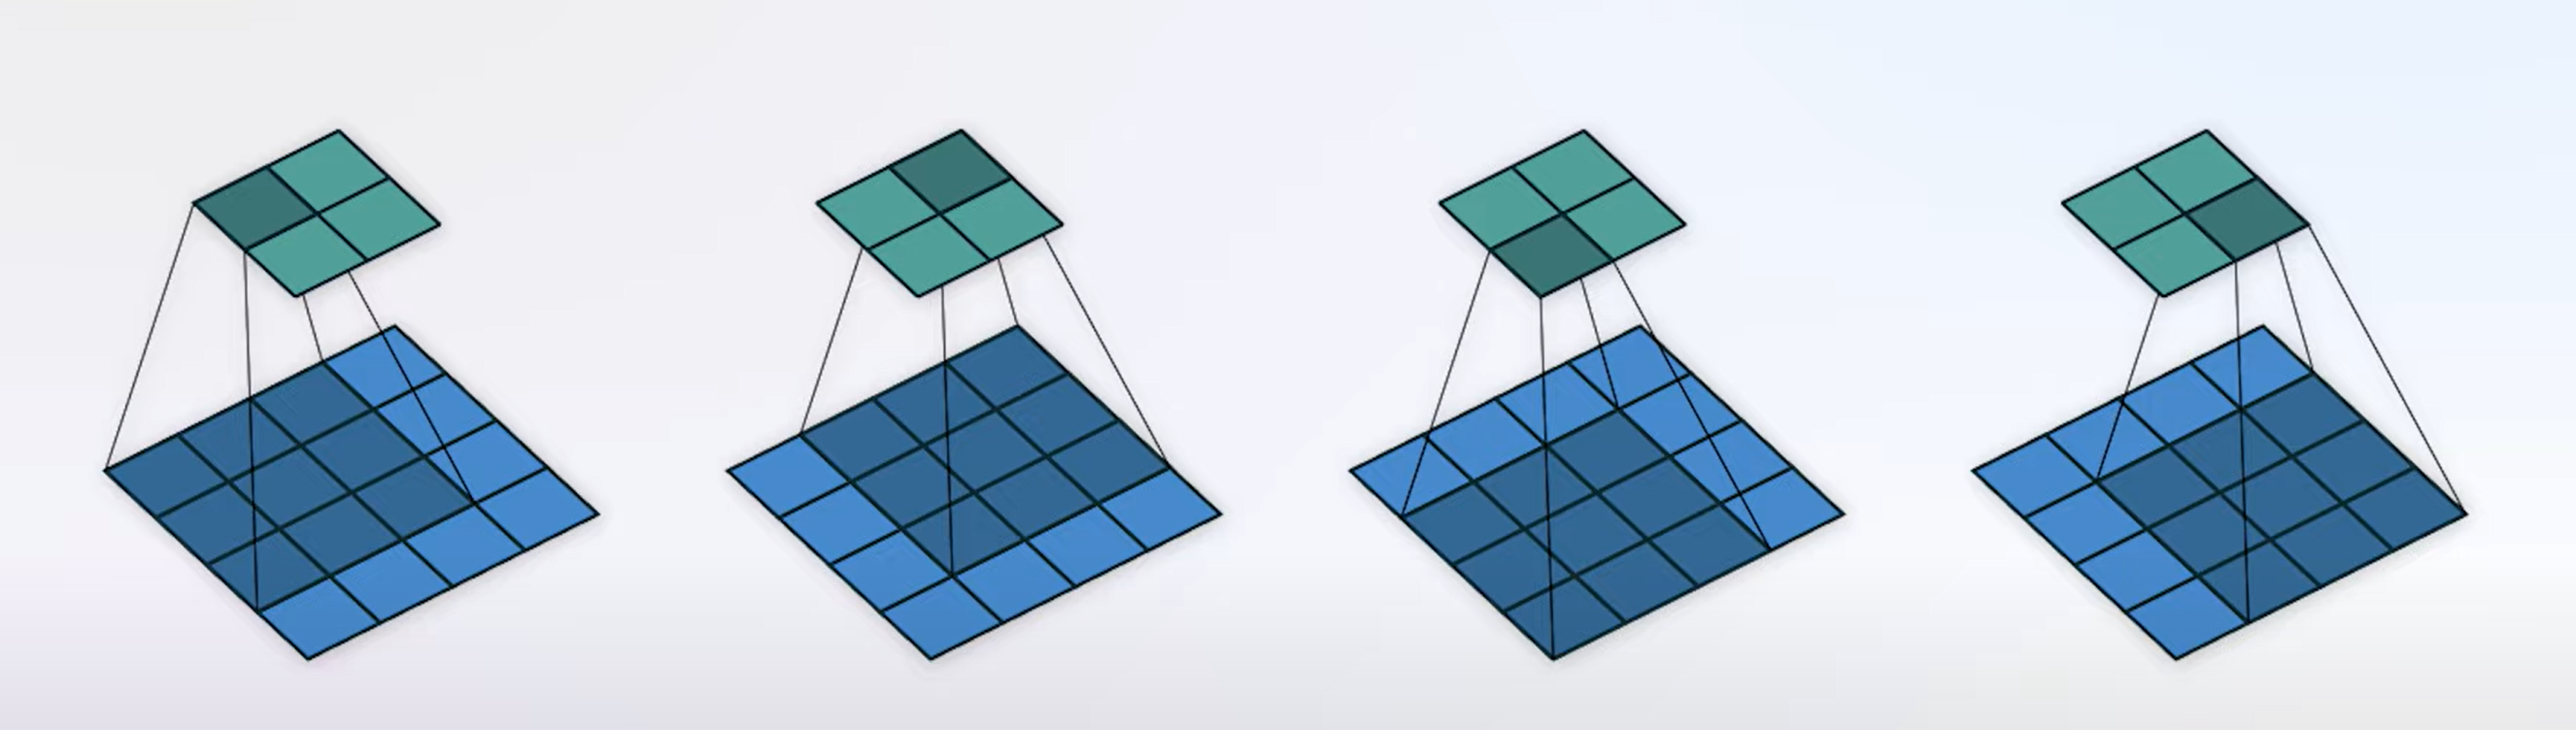
---

#### 为什么叫“转置”卷积？
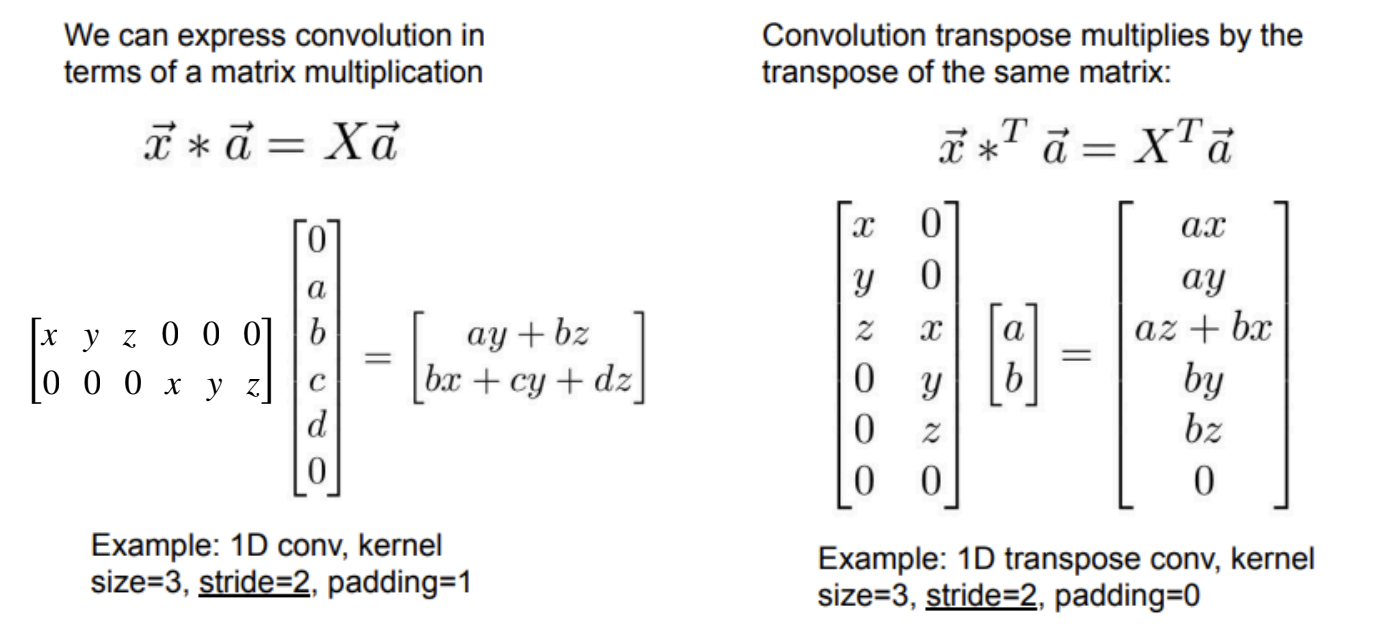

这个名字来源于它的数学等价形式：**矩阵乘法**。

1.  **标准卷积可以表示为矩阵乘法**：
    任何卷积操作都可以被“展开”成一个巨大的稀疏矩阵 `C`（包含了卷积核的权重）与一个被展平的输入向量 `x` 相乘，得到一个展平的输出向量 `y`。
    `y = C * x`

2.  **转置卷积就是与转置矩阵相乘**：
    转置卷积操作在数学上等价于用这个矩阵的**转置** `C^T` 去乘以一个向量。
    `x' = C^T * y'`

    这里的 `y'` 是小的输入特征图（被展平），`x'` 是大的输出特征图（被展平）。因为这个操作使用了**转置矩阵** `C^T`，所以它被命名为“转置卷积”。

#### 总结

| 特性 | 标准卷积 (Convolution) | 转置卷积 (Transposed Convolution) |
| :--- | :--- | :--- |
| **目标** | 特征提取，**下采样**（或保持尺寸） | **上采样**，恢复空间分辨率 |
| **尺寸变化** | 大 -> 小 (当 stride > 1) | 小 -> 大 |
| **操作核心** | **汇集信息**：输出中的一个点，是输入中一个区域信息的汇集。 | **扩散信息**：输入中的一个点，将信息扩散到输出的一个区域。 |
| **步长(Stride)的意义** | 控制卷积核在**输入**上滑动的步子有多大。 | 控制输入像素在**输出**上“投射”的间隔有多大。 |
| **学习性** | 是一个**可学习**的下采样/特征提取方法。 | 是一个**可学习**的上采样方法（比插值等固定方法更强大）。 |

### UNET
转置卷积还是会丢失原图的精细信息，导致分割边界有错误。UNET在每一层都直接copy了原图的一部分，对原图信息起到了保护作用。

*   **U-Net的解决方案**：
    *   引入“**跳跃连接**”（Skip Connections）。
    *   将编码器中**相同分辨率**的特征图直接拼接到解码器的对应层。
    *   **作用**：这样解码器在做上采样时，既能利用编码器传来的**高级语义信息**（全局信息），又能利用跳跃连接送来的**低级细节信息**（局部信息），从而大大提升分割的精细度。
    *   这种结构使得**瓶颈（Bottleneck）**部分只需专注于传递全局上下文信息，而无需记忆所有空间细节。
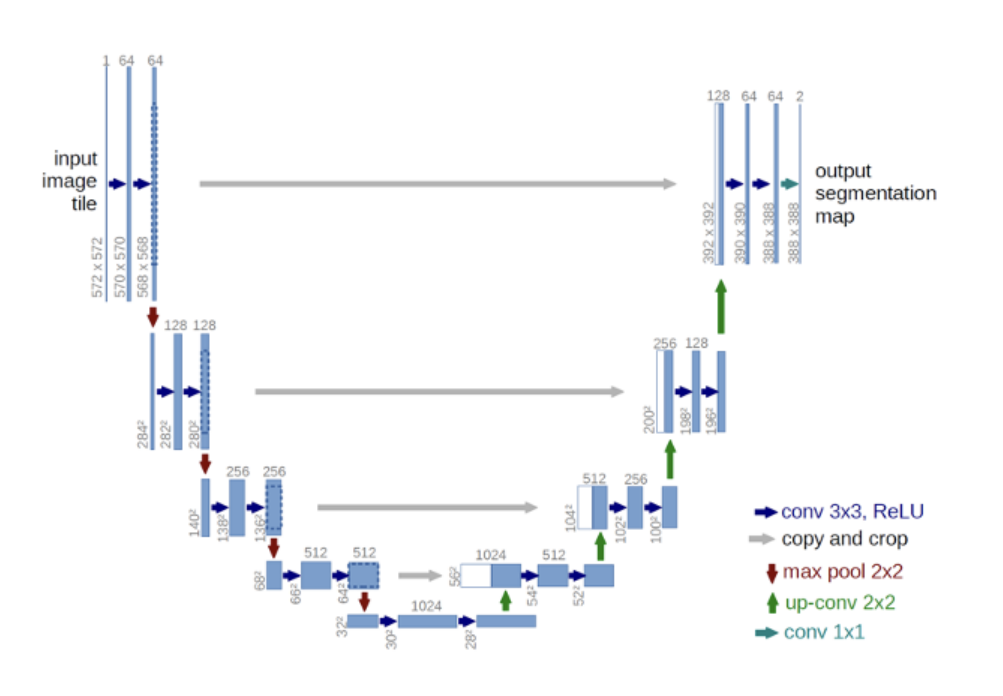

## 4. 分割模型的评估

*   **像素准确率（Pixel Accuracy）**：最简单的指标，即被正确分类的像素占总像素的比例。但在类别不均衡时（比如小物体）有误导性。
*   **交并比（Intersection over Union, IoU）**：更常用、更公平的指标。计算的是“预测区域”与“真实区域”的**交集**面积除以**并集**面积。对每个类别计算IoU后取平均，得到**mIoU**（Mean IoU），是衡量分割模型性能的黄金标准。